# Import libraries and load data

- stores.csv contains anonymized info about the 45 stores such as type and size of stores
- train.csv is historical training data from 2nd May 2010 until 1st November 2012 
- test.csv is identical to train.csv exceot the withheld weekly sales (you must predict the sales for each triplet store, deparment, and date in this file
- features.csv containts additional data related to the store, department, and regional activity for the given dates

In [1]:
# import libraries

import numpy as np 
import pandas as pd 

# data viz libraries
import seaborn as sns
sns.set(style="whitegrid") # to make charts look better
import matplotlib.pyplot as plt
%matplotlib inline

# for functions
from tqdm import tqdm

# for ML
import datetime
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
pd.set_option('display.max_columns', None)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report


In [2]:
# load datasets

dataFeatures = pd.read_csv("C:/Users/digit/Desktop/Ironhack/project-week-9-final-project/data/features.csv")
dataStores = pd.read_csv("C:/Users/digit/Desktop/Ironhack/project-week-9-final-project/data/stores.csv")
dataTest = pd.read_csv("C:/Users/digit/Desktop/Ironhack/project-week-9-final-project/data/test.csv")
dataTrain = pd.read_csv("C:/Users/digit/Desktop/Ironhack/project-week-9-final-project/data/train.csv")


# EDA and Data Cleaning

Here we will explore the provided datasets, perform data cleaning and data wrangling

In [3]:
dataStores.head(5)

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
dataStores.shape 

(45, 3)

In [5]:
dataFeatures.tail(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


In [6]:
dataFeatures.shape

(8190, 12)

In [7]:
# we will start by merging dataStores and dataFeatures since Features is the extension of Stores
FeatSto = dataFeatures.merge(dataStores, how="inner", on="Store")

# check the head of the new df
FeatSto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [8]:
FeatSto.shape

(8190, 14)

In [9]:
# check the dtypes in FeatSto

FeatSto.dtypes

# Type is of categorical nature
# IsHoliday of binary categorical nature 

# the rest are numerical
# Date is an object and we will convert it into datetime

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
dtype: object

In [10]:
FeatSto.isnull().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
Type               0
Size               0
dtype: int64

**Now we will inspect dataTest and dataTrain**

In [11]:
dataTest.head(5)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [12]:
dataTest.shape

(115064, 4)

In [13]:
# as we can see  dataTrain includes additional Weekly_Sales
dataTrain.tail(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [14]:
dataTrain.shape

(421570, 5)

In [15]:
# to merge dataTest and dataTrain later we need to create an additiona Weekly_Sales column in dataTest
# and fill it with NaN

dataTest["Weekly_Sales"] = np.nan

# show the result

dataTest

,Store,Dept,Date,IsHoliday,Weekly_Sales
0,1,1,2012-11-02,False,NaN
1,1,1,2012-11-09,False,NaN
2,1,1,2012-11-16,False,NaN
3,1,1,2012-11-23,True,NaN
4,1,1,2012-11-30,False,NaN
...,...,...,...,...,...
115059,45,98,2013-06-28,False,NaN
115060,45,98,2013-07-05,False,NaN
115061,45,98,2013-07-12,False,NaN
115062,45,98,2013-07-19,False,NaN


In [16]:
# merge dataTest with FeatSto -> dfwTest
# merge dataTrain with Featsto ->dfwTrain

# now we have 2 dataframes with 
# a) FeatSto with dataTest
# b) FeatSto with dataTrain
dfwTest = pd.merge(FeatSto, dataTest, how="inner", on=["Store", "Date", "IsHoliday"])
dfwTrain = pd.merge(FeatSto, dataTrain, how="inner", on=["Store", "Date", "IsHoliday"])

dfwTest.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
0,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,1,NaN
1,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,2,NaN
2,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,3,NaN
3,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,4,NaN
4,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,5,NaN


In [17]:
dfwTest.shape

(115064, 16)

In [18]:
dfwTrain.tail(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48
421569,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,98,1076.80


In [19]:
dfwTrain.shape

(421570, 16)

In [20]:
# create a column to distinguish dataTest and dataTrain within 

dfwTest["train/test"] = "Test"
dfwTrain["train/test"] = "Train"

In [21]:
dfwTest.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test
0,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,1,NaN,Test
1,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,2,NaN,Test
2,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,3,NaN,Test
3,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,4,NaN,Test
4,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,5,NaN,Test


In [22]:
dfwTrain.tail(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test
421565,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80,Train
421566,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31,Train
421567,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47,Train
421568,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48,Train
421569,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,98,1076.80,Train


In [23]:
# now we can merge all datasets together

df_total = pd.concat([dfwTest, dfwTrain], axis=0, ignore_index= True)

# show the head of the total dataframe

df_total.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test
0,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,1,NaN,Test
1,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,2,NaN,Test
2,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,3,NaN,Test
3,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,4,NaN,Test
4,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,5,NaN,Test


In [24]:
# show the tail

df_total.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test
536629,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,93,2487.80,Train
536630,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,94,5203.31,Train
536631,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,95,56017.47,Train
536632,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,97,6817.48,Train
536633,45,2012-10-26,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,False,B,118221,98,1076.80,Train


In [25]:
# check the shape of df_total

df_total.shape

(536634, 17)

In [26]:
# check the dtypes of df_total

df_total.dtypes

# Type, IsHoliday and train/test of categorical nature

Store             int64
Date             object
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday          bool
Type             object
Size              int64
Dept              int64
Weekly_Sales    float64
train/test       object
dtype: object

In [27]:
# now we can check for missing values

df_total.isnull().sum()

Store                0
Date                 0
Temperature          0
Fuel_Price           0
MarkDown1       271038
MarkDown2       338949
MarkDown3       294308
MarkDown4       299491
MarkDown5       270138
CPI              38162
Unemployment     38162
IsHoliday            0
Type                 0
Size                 0
Dept                 0
Weekly_Sales    115064
train/test           0
dtype: int64

In [28]:
# calculate the percentage of missing values in each column

df_total.isnull().sum() / len(df_total)

# if the column contains 85% missing values then it should be dropped

Store           0.000000
Date            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.505070
MarkDown2       0.631620
MarkDown3       0.548433
MarkDown4       0.558092
MarkDown5       0.503393
CPI             0.071114
Unemployment    0.071114
IsHoliday       0.000000
Type            0.000000
Size            0.000000
Dept            0.000000
Weekly_Sales    0.214418
train/test      0.000000
dtype: float64

In [29]:
# instead of dropping, we will fill the NaN values with zero values
df_total.fillna(0, inplace=True)

df_total.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test
0,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,1,0.0,Test
1,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,2,0.0,Test
2,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,3,0.0,Test
3,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,4,0.0,Test
4,1,2012-11-02,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,False,A,151315,5,0.0,Test


In [30]:
# check for missing values again

df_total.isnull().sum()

Store           0
Date            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
Dept            0
Weekly_Sales    0
train/test      0
dtype: int64

In [42]:
# check for duplicated values

df_total.duplicated().sum()

0

In [31]:
df_total['Month'] = pd.to_datetime(df_total['Date']).dt.month
df_total.sample(5) 

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test,Month
471324,38,2011-01-28,50.74,3.342,0.00,0.00,0.00,0.00,0.00,127.580032,14.021,False,C,39690,2,10879.80,Train,1
356861,25,2011-05-27,67.18,3.985,0.00,0.00,0.00,0.00,0.00,208.556714,7.287,False,B,128107,56,18992.21,Train,5
256120,15,2010-11-26,40.71,3.186,0.00,0.00,0.00,0.00,0.00,132.836933,8.067,True,B,123737,41,2234.00,Train,11
241167,13,2012-04-20,50.24,3.845,22464.84,8216.22,70.45,1561.38,7307.24,131.117333,5.965,False,A,219622,83,5386.80,Train,4
201614,9,2012-07-13,82.39,3.256,3031.81,0.00,2.02,47.76,4554.39,225.677146,5.277,False,B,125833,28,143.10,Train,7


In [32]:
df_total["Year"] = pd.to_datetime(df_total["Date"]).dt.year 
df_total.sample(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test,Month,Year
254083,15,2010-04-30,49.09,3.042,0.00,0.00,0.0,0.00,0.00,132.064433,8.185,False,B,123737,92,15895.30,Train,4,2010
102750,40,2013-04-19,45.17,3.678,2322.79,1.59,20.1,133.68,1429.80,139.122613,3.684,False,A,155083,20,0.00,Test,4,2013
390715,28,2012-06-08,84.83,4.103,9026.85,101.20,-29.1,833.67,11752.37,130.889677,11.627,False,A,206302,41,736.83,Train,6,2012
436882,34,2010-06-04,72.17,2.701,0.00,0.00,0.0,0.00,0.00,126.136065,9.593,False,A,158114,90,40221.74,Train,6,2010
177542,7,2011-01-21,25.40,2.973,0.00,0.00,0.0,0.00,0.00,191.573192,8.818,False,B,70713,92,26552.10,Train,1,2011


In [33]:
# we can drop Date column now

df_total.drop(["Date"], inplace=True, axis=1)
df_total.sample(5)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test,Month,Year
400880,29,76.74,3.772,27921.89,341.19,9.08,1673.62,1983.79,138.143774,9.419,False,B,93638,83,1019.66,Train,8,2012
482280,39,73.79,3.274,0.00,0.00,0.00,0.00,0.00,216.088526,7.716,False,A,184109,82,20785.49,Train,10,2011
456547,36,84.62,2.562,0.00,0.00,0.00,0.00,0.00,210.329211,8.360,False,A,39910,14,1827.87,Train,8,2010
138317,3,53.76,2.708,0.00,0.00,0.00,0.00,0.00,214.915353,7.564,False,B,37392,87,795.71,Train,12,2010
226752,12,51.72,3.674,0.00,0.00,0.00,0.00,0.00,128.264750,14.021,False,B,112238,5,32578.83,Train,3,2011


In [64]:
df_total["Weekly_Sales"].value_counts()

0.00        115137
10.00          353
5.00           289
20.00          232
15.00          215
             ...  
32114.81         1
11340.32         1
12632.79         1
99258.48         1
738.50           1
Name: Weekly_Sales, Length: 359464, dtype: int64

In [35]:
df_total["IsHoliday"] = df_total["IsHoliday"].map({False: "0", True: "1"})

df_total.sample(5)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test,Month,Year
533341,45,48.71,3.492,140.87,384.82,26961.99,28.59,1110.12,188.350400,8.523,1,B,118221,26,11881.52,Train,11,2011
280335,17,43.92,3.793,11072.17,0.00,43.74,2299.75,4192.05,131.037548,6.235,0,B,93188,33,5613.12,Train,4,2012
523549,44,75.59,3.553,0.00,0.00,0.00,0.00,0.00,129.133839,6.560,0,C,39910,72,43.40,Train,7,2011
131180,2,89.64,3.533,0.00,0.00,0.00,0.00,0.00,215.450863,7.852,0,A,202307,13,48399.60,Train,9,2011
185325,8,74.78,2.669,0.00,0.00,0.00,0.00,0.00,214.592812,6.315,0,A,155078,46,15975.26,Train,7,2010


In [36]:
df_total["Type"] = df_total["Type"].map({"A":0, "B":1, "C":2})
df_total.sample(5)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test,Month,Year
181011,7,7.46,3.077,3167.26,5926.48,0.54,191.84,1415.69,196.733052,8.256,0,1,70713,94,42.66,Train,1,2012
262442,15,66.98,3.997,3669.07,-6.69,0.00,2813.59,1610.18,138.281452,8.193,0,1,123737,60,18.00,Train,8,2012
206263,10,56.75,3.336,0.00,0.00,0.00,0.00,0.00,127.440484,8.744,0,1,126512,32,17477.82,Train,1,2011
108187,42,91.98,3.771,10.63,0.00,8.24,0.00,1735.58,0.000000,0.000,0,2,39690,67,0.00,Test,6,2013
447971,35,64.50,2.706,0.00,0.00,0.00,0.00,0.00,136.633807,8.861,0,1,103681,28,604.02,Train,9,2010


In [37]:
from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
df_total['Type']= le.fit_transform(df_total['Type'])

In [ ]:
# took a sample with the size of 5000, which should be enough to better understand the relationship between the columns

# had problems with loading the plot, that's why I saved an image of it

# sns.pairplot(df_num.sample(5000), size = 5)

# sns.pairplot(df_num.sample(5000))

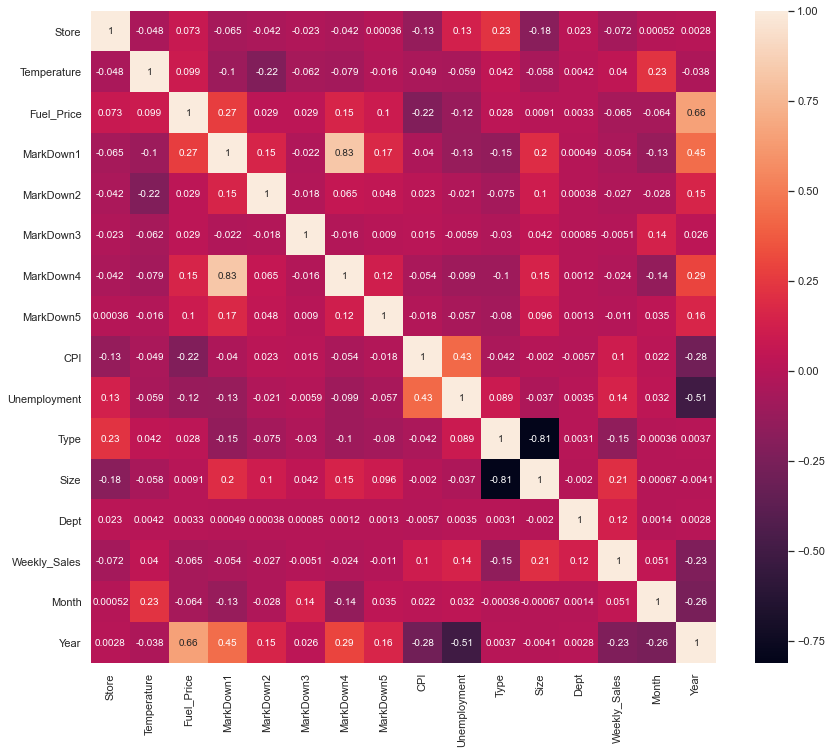

In [44]:
# correlation matrix
corr_matrix = df_total.corr(method="pearson") # we chose 'pearson'

# plot a heatmap
fig, ax = plt.subplots(figsize=(14,12))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

# values range between (-1,1)
# strong correlation between MarkDown1 and MarkDown4
# some correlation between Fuel_Price and Year


In [45]:
corr_matrix

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Dept,Weekly_Sales,Month,Year
Store,1.000000,-0.048379,0.073123,-0.065246,-0.042013,-0.023277,-0.041543,0.000356,-0.133847,0.133553,0.227481,-0.183736,0.023061,-0.072140,0.000520,0.002782
Temperature,-0.048379,1.000000,0.099235,-0.104930,-0.220472,-0.061890,-0.078796,-0.016038,-0.048878,-0.058701,0.041971,-0.058202,0.004151,0.039928,0.225541,-0.037865
Fuel_Price,0.073123,0.099235,1.000000,0.269523,0.029201,0.028873,0.152282,0.100314,-0.219331,-0.121736,0.028073,0.009058,0.003273,-0.065185,-0.064187,0.657853
MarkDown1,-0.065246,-0.104930,0.269523,1.000000,0.153091,-0.021764,0.825862,0.174847,-0.040013,-0.131771,-0.151195,0.199747,0.000492,-0.053529,-0.132286,0.445504
MarkDown2,-0.042013,-0.220472,0.029201,0.153091,1.000000,-0.017901,0.065154,0.047690,0.023112,-0.020535,-0.075150,0.104394,0.000384,-0.027302,-0.028154,0.154407
MarkDown3,-0.023277,-0.061890,0.028873,-0.021764,-0.017901,1.000000,-0.016410,0.009042,0.014653,-0.005911,-0.030313,0.041505,0.000852,-0.005122,0.142238,0.026240
MarkDown4,-0.041543,-0.078796,0.152282,0.825862,0.065154,-0.016410,1.000000,0.116872,-0.054137,-0.099436,-0.103227,0.145301,0.001163,-0.024305,-0.143169,0.293940
MarkDown5,0.000356,-0.016038,0.100314,0.174847,0.047690,0.009042,0.116872,1.000000,-0.017712,-0.056869,-0.079618,0.095720,0.001332,-0.011073,0.034657,0.160348
CPI,-0.133847,-0.048878,-0.219331,-0.040013,0.023112,0.014653,-0.054137,-0.017712,1.000000,0.432227,-0.041631,-0.002022,-0.005665,0.103451,0.022174,-0.281757
Unemployment,0.133553,-0.058701,-0.121736,-0.131771,-0.020535,-0.005911,-0.099436,-0.056869,0.432227,1.000000,0.089076,-0.036942,0.003475,0.144122,0.031726,-0.505501


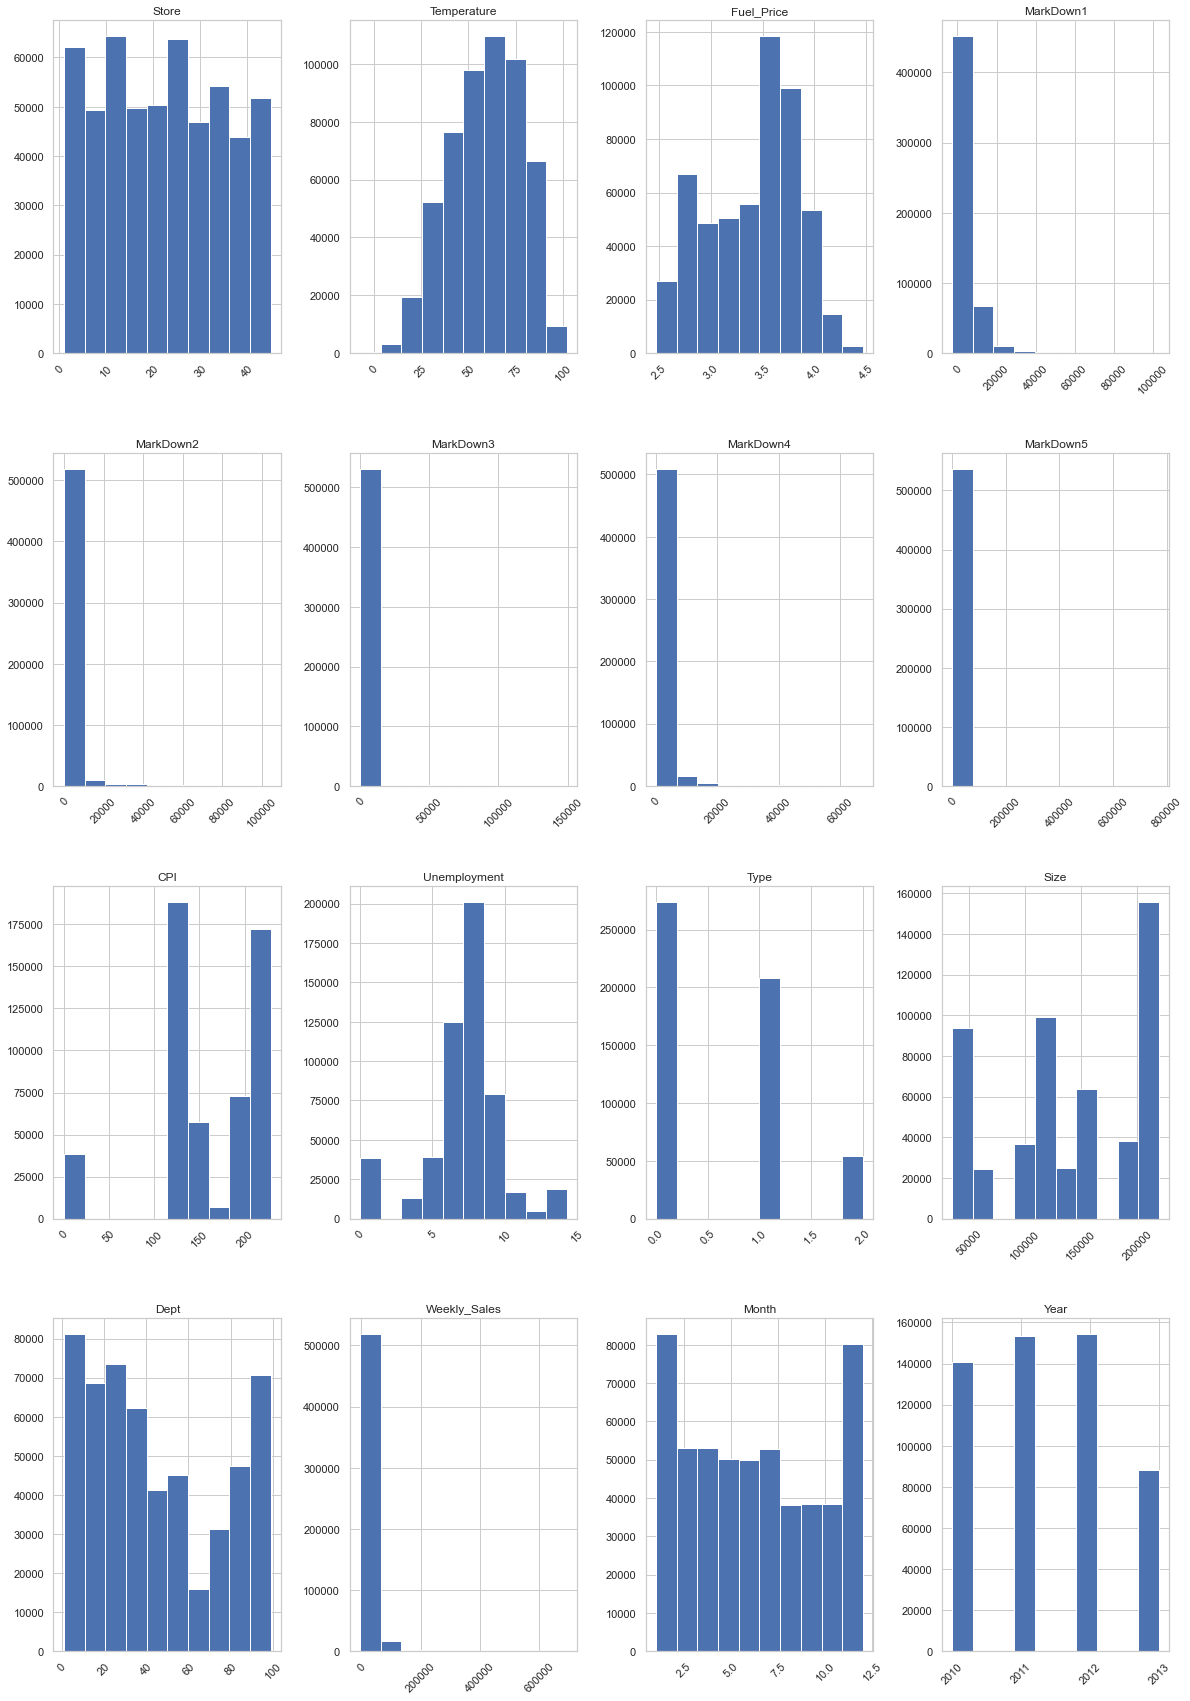

In [46]:
# plot a histogram to check frequency distribution

df_total.hist(figsize=(20,30), xrot=45)
plt.show()

# Temperature is left-skewed (negative skewness)
# Fuel_Price is left-skwewed
#

In [49]:
# let's show the key of df_total
# so I can copy and paste them into factors in the next cell but without the Weekly_Sales
df_total.keys()

Index(['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'Weekly_Sales', 'train/test',
       'Month', 'Year'],
      dtype='object')

In [69]:
# select the possible variables

factors = ['Store', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday', 'Type', 'Size', 'Dept', 'train/test',
       'Month', 'Year']

df_total[factors].head(5)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,train/test,Month,Year
0,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,1,Test,11,2012
1,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,2,Test,11,2012
2,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,3,Test,11,2012
3,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,4,Test,11,2012
4,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,5,Test,11,2012


In [70]:
# work on the test data

import sklearn.model_selection as model_selection

train = df_total.loc[df_total["train/test"] == "Train"]

In [71]:
test = df_total.loc[df_total["train/test"] == "Test"]

In [72]:
test.head(5)

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Dept,Weekly_Sales,train/test,Month,Year
0,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,1,0.0,Test,11,2012
1,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,2,0.0,Test,11,2012
2,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,3,0.0,Test,11,2012
3,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,4,0.0,Test,11,2012
4,1,55.32,3.386,6766.44,5147.7,50.82,3639.9,2737.42,223.462779,6.573,0,0,151315,5,0.0,Test,11,2012


In [73]:
# seperate the dataset into dependent (Y) and indenpendent variables (X). 


X = train[factors]

y = df_total['Weekly_Sales']

print(X.shape)
print(y.shape)

(421570, 17)
(536634,)


In [68]:
# Dividing the dataset into Test and Train.
# Reproducability is also set up with random state of 0.42

#X_train, X_test, y_train, y_test =\
  #model_selection.train_test_split(X,
                                   #y, 
                                   #test_size=0.30,  # size of the split.
                                   #random_state=42  # to make sure your models always start from the same states
                                   #)

ValueError: Found input variables with inconsistent numbers of samples: [421570, 536634]